# StyleTTS 2 Demo (LJSpeech)


### Utils

In [2]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [3]:
%cd ..

/rhome/eingerman/Projects/DeepLearning/TTS/StyleTTS2


In [4]:
%pwd

'/rhome/eingerman/Projects/DeepLearning/TTS/StyleTTS2'

In [5]:
# load packages
import time
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa
from nltk.tokenize import word_tokenize

from models import *
from utils import *
from text_utils import TextCleaner
textclenaer = TextCleaner()

%matplotlib inline

/rhome/eingerman/mambaforge/envs/tts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


177


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

def length_to_mask(lengths):
    mask = torch.arange(lengths.max()).unsqueeze(0).expand(lengths.shape[0], -1).type_as(lengths)
    mask = torch.gt(mask+1, lengths.unsqueeze(1))
    return mask

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def compute_style(ref_dicts):
    reference_embeddings = {}
    for key, path in ref_dicts.items():
        wave, sr = librosa.load(path, sr=24000)
        audio, index = librosa.effects.trim(wave, top_db=30)
        if sr != 24000:
            audio = librosa.resample(audio, sr, 24000)
        mel_tensor = preprocess(audio).to(device)

        with torch.no_grad():
            ref = model.style_encoder(mel_tensor.unsqueeze(1))
        reference_embeddings[key] = (ref.squeeze(1), audio)
    
    return reference_embeddings

### Load models

In [8]:
# load phonemizer
import phonemizer
global_phonemizer = phonemizer.backend.EspeakBackend(language='en-us', preserve_punctuation=True,  with_stress=True)

In [9]:
config = yaml.safe_load(open("Models/LJSpeech/config.yml"))

# load pretrained ASR model
ASR_config = config.get('ASR_config', False)
ASR_path = config.get('ASR_path', False)
text_aligner = load_ASR_models(ASR_path, ASR_config)

# load pretrained F0 model
F0_path = config.get('F0_path', False)
pitch_extractor = load_F0_models(F0_path)

# load BERT model
from Utils.PLBERT.util import load_plbert
BERT_path = config.get('PLBERT_dir', False)
plbert = load_plbert(BERT_path)

In [10]:
model = build_model(recursive_munch(config['model_params']), text_aligner, pitch_extractor, plbert)
_ = [model[key].eval() for key in model]
_ = [model[key].to(device) for key in model]

/rhome/eingerman/mambaforge/envs/tts/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/rhome/eingerman/mambaforge/envs/tts/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
params_whole = torch.load("Models/LJSpeech/epoch_2nd_00100.pth", map_location='cpu')
params = params_whole['net']

In [12]:
for key in model:
    if key in params:
        print('%s loaded' % key)
        try:
            model[key].load_state_dict(params[key])
        except:
            from collections import OrderedDict
            state_dict = params[key]
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                name = k[7:] # remove `module.`
                new_state_dict[name] = v
            # load params
            model[key].load_state_dict(new_state_dict, strict=False)
#             except:
#                 _load(params[key], model[key])
_ = [model[key].eval() for key in model]

bert loaded
bert_encoder loaded
predictor loaded
decoder loaded


text_encoder loaded
predictor_encoder loaded
style_encoder loaded
diffusion loaded
text_aligner loaded
pitch_extractor loaded
mpd loaded
msd loaded
wd loaded


In [13]:
from Modules.diffusion.sampler import DiffusionSampler, ADPM2Sampler, KarrasSchedule

In [14]:
sampler = DiffusionSampler(
    model.diffusion.diffusion,
    sampler=ADPM2Sampler(),
    sigma_schedule=KarrasSchedule(sigma_min=0.0001, sigma_max=3.0, rho=9.0), # empirical parameters
    clamp=False
)

### Synthesize speech

In [15]:
# synthesize a text
text = ''' StyleTTS 2 is a text-to-speech model that leverages style diffusion and adversarial training with large speech language models to achieve human-level text-to-speech synthesis. '''

In [16]:
def inference(text, noise, diffusion_steps=5, embedding_scale=1):
    text = text.strip()
    text = text.replace('"', '')
    ps = global_phonemizer.phonemize([text])
    ps = word_tokenize(ps[0])
    ps = ' '.join(ps)

    tokens = textclenaer(ps)
    tokens.insert(0, 0)
    tokens = torch.LongTensor(tokens).to(device).unsqueeze(0)
    
    with torch.no_grad():
        input_lengths = torch.LongTensor([tokens.shape[-1]]).to(tokens.device)
        text_mask = length_to_mask(input_lengths).to(tokens.device)

        t_en = model.text_encoder(tokens, input_lengths, text_mask)
        bert_dur = model.bert(tokens, attention_mask=(~text_mask).int())
        d_en = model.bert_encoder(bert_dur).transpose(-1, -2) 

        s_pred = sampler(noise, 
              embedding=bert_dur[0].unsqueeze(0), num_steps=diffusion_steps,
              embedding_scale=embedding_scale).squeeze(0)

        s = s_pred[:, 128:]
        ref = s_pred[:, :128]

        d = model.predictor.text_encoder(d_en, s, input_lengths, text_mask)

        x, _ = model.predictor.lstm(d)
        duration = model.predictor.duration_proj(x)
        duration = torch.sigmoid(duration).sum(axis=-1)
        pred_dur = torch.round(duration.squeeze()).clamp(min=1)

        pred_dur[-1] += 5

        pred_aln_trg = torch.zeros(input_lengths, int(pred_dur.sum().data))
        c_frame = 0
        for i in range(pred_aln_trg.size(0)):
            pred_aln_trg[i, c_frame:c_frame + int(pred_dur[i].data)] = 1
            c_frame += int(pred_dur[i].data)

        # encode prosody
        en = (d.transpose(-1, -2) @ pred_aln_trg.unsqueeze(0).to(device))
        F0_pred, N_pred = model.predictor.F0Ntrain(en, s)
        out = model.decoder((t_en @ pred_aln_trg.unsqueeze(0).to(device)), 
                                F0_pred, N_pred, ref.squeeze().unsqueeze(0))
        
    return out.squeeze().cpu().numpy()

#### Basic synthesis (5 diffusion steps)

In [17]:
start = time.time()
noise = torch.randn(1,1,256).to(device)
wav = inference(text, noise, diffusion_steps=5, embedding_scale=1)
rtf = (time.time() - start) / (len(wav) / 24000)
print(f"RTF = {rtf:5f}")
import IPython.display as ipd
display(ipd.Audio(wav, rate=24000))

RTF = 0.121656


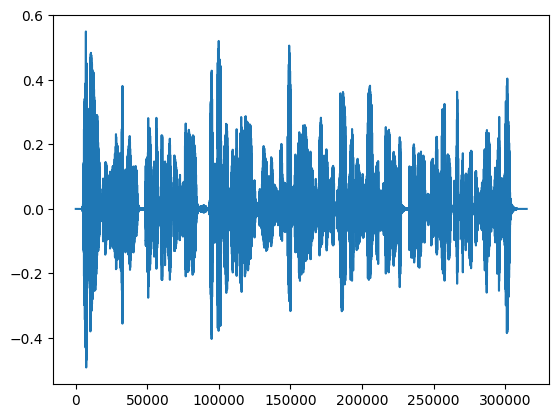

In [18]:
import matplotlib.pylab as pl
pl.plot(wav)

#### With higher diffusion steps (more diverse)
Since the sampler is ancestral, the higher the stpes, the more diverse the samples are, with the cost of slower synthesis speed.

In [19]:
start = time.time()
noise = torch.randn(1,1,256).to(device)
wav = inference(text, noise, diffusion_steps=10, embedding_scale=1)
rtf = (time.time() - start) / (len(wav) / 24000)
print(f"RTF = {rtf:5f}")
import IPython.display as ipd
display(ipd.Audio(wav, rate=24000))

RTF = 0.115787


### Speech expressiveness
The following section recreates the samples shown in [Section 6](https://styletts2.github.io/#emo) of the demo page.

#### With embedding_scale=1
This is the classifier-free guidance scale. The higher the scale, the more conditional the style is to the input text and hence more emotional. 

In [20]:
texts = {}
texts['Happy'] = "We are happy to invite you to join us on a journey to the past, where we will visit the most amazing monuments ever built by human hands."
texts['Sad'] = "I am sorry to say that we have suffered a severe setback in our efforts to restore prosperity and confidence."
texts['Angry'] = "The field of astronomy is a joke! Its theories are based on flawed observations and biased interpretations!"
texts['Surprised'] = "I can't believe it! You mean to tell me that you have discovered a new species of bacteria in this pond?"

for k,v in texts.items():
    noise = torch.randn(1,1,256).to(device)
    wav = inference(v, noise, diffusion_steps=10, embedding_scale=1)
    print(k + ": ")
    display(ipd.Audio(wav, rate=24000, normalize=False))

Happy: 


Sad: 


Angry: 


Surprised: 


#### With embedding_scale=2

In [21]:
texts = {}
texts['Happy'] = "We are happy to invite you to join us on a journey to the past, where we will visit the most amazing monuments ever built by human hands."
texts['Sad'] = "I am sorry to say that we have suffered a severe setback in our efforts to restore prosperity and confidence."
texts['Angry'] = "The field of astronomy is a joke! Its theories are based on flawed observations and biased interpretations!"
texts['Surprised'] = "I can't believe it! You mean to tell me that you have discovered a new species of bacteria in this pond?"

for k,v in texts.items():
    noise = torch.randn(1,1,256).to(device)
    wav = inference(v, noise, diffusion_steps=10, embedding_scale=2) # embedding_scale=2 for more pronounced emotion
    print(k + ": ")
    display(ipd.Audio(wav, rate=24000, normalize=False))

Happy: 


Sad: 


Angry: 


Surprised: 


### Long-form generation
This section includes basic implementation of Algorithm 1 in the paper for consistent longform audio generation. The example passage is taken from [Section 5](https://styletts2.github.io/#long) of the demo page. 

In [45]:
passage = '''If the supply of fruit is greater than the family needs, it may be made a source of income by sending the fresh fruit to the market if there is one near enough, or by preserving, canning, and making jelly for sale. To make such an enterprise a success the fruit and work must be first class. There is magic in the word "Homemade," when the product appeals to the eye and the palate; but many careless and incompetent people have found to their sorrow that this word has not magic enough to float inferior goods on the market. As a rule large canning and preserving establishments are clean and have the best appliances, and they employ chemists and skilled labor. The home product must be very good to compete with the attractive goods that are sent out from such establishments. Yet for first-class homemade products there is a market in all large cities. All first-class grocers have customers who purchase such goods.'''

# passage='''It was in the summer of '89, not long after my marriage, that the events occurred which I am now about to summarise. 
# I had returned to civil practice and had finally abandoned Holmes in his Baker Street rooms, although I continually visited him and occasionally even persuaded him to forgo his Bohemian habits so far as to come and visit us. My practice had steadily increased, and as I happened to live at no very great distance from Paddington Station, I got a few patients from among the officials. One of these, whom I had cured of a painful and lingering disease, was never weary of advertising my virtues and of endeavouring to send me on every sufferer over whom he might have any influence.'''


# passage = '''“He began a sentence: “I am–” but when he was taken by surprise, every sentence became an adventure in the woods; as soon as he could no longer see the light of the clearing from which he’d entered, he would realize that the crumbs he’d dropped for bearings had been eaten by birds, silent deft darting things which he couldn’t quite see in the darkness but which were so numerous and swarming in their hunger that it seemed as if they were the darkness, as if the darkness weren’t uniform, weren’t an absence of light but a teeming corpuscular thing, and indeed when as a studious teenager he’d encountered the word “crepuscular” in McKay’s Treasury of English Verse, the corpuscles of biology had bled into his understanding of the word, so that for his entire adult life he’d seen in twilight a corpuscularity, as of the graininess of the high-speed film necessary for photography under conditions of low ambient light, as of a kind of sinister decay; and hence the panic of a man betrayed deep in the woods whose darkness was the darkness of starlings blotting out the sunset or black ants storming a dead opossum, a darkness that didn’t just exit but actively consumed the bearings that he’d sensibly established for himself, lest he be lost; but in the instant of realizing he was lost, time became marvelously slow and he discovered hitherto unguessed eternities in the space between one word and the next, or rather he became trapped in that space between one word and the next, or rather he became trapped in that space between words and could only stand and watch as time sped on without him, the thoughtless boyish part of him crashing on out of sight blindly through the woods while he, trapped, the grownup Al, watched in oddly impersonal suspense to see if the panic-stricken little boy might, despite no longer knowing where he was or at what point he’d entered the woods of this sentence, still manage to blunder into the clearing where Enid was waiting for him, unaware of any woods–“packing my suitcase,” he heard himself say.”'''

In [51]:
# text = passage.split('.')[0].strip()
text = passage.strip()

text = text.replace('"', '')
ps = global_phonemizer.phonemize([text])
ps = word_tokenize(ps[0])
ps = ' '.join(ps)
tokens = textclenaer(ps)
tokens.insert(0, 0)
print(len(tokens))
tokens = torch.LongTensor(tokens).to(device).unsqueeze(0)
with torch.no_grad():

    input_lengths = torch.LongTensor([tokens.shape[-1]]).to(tokens.device)
    text_mask = length_to_mask(input_lengths).to(tokens.device)
    t_en = model.text_encoder(tokens, input_lengths, text_mask)
    bert_dur = model.bert(tokens, attention_mask=(~text_mask).int())
    print(bert_dur.shape)

970


RuntimeError: The expanded size of the tensor (970) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 970].  Tensor sizes: [1, 512]

'“ hiː bɪɡˈæn ɐ sˈɛntəns : “ aɪˈæm ” bˌʌt wɛn hiː wʌz tˈeɪkən baɪ sɚpɹˈaɪz , ˈɛvɹi sˈɛntəns bɪkˌeɪm ɐn ɐdvˈɛntʃɚɹ ɪnðə wˈʊdz ; æz sˈuːn æz hiː kʊd nˌoʊ lˈɑːŋɡɚ sˈiː ðə lˈaɪt ʌvðə klˈɪɹɪŋ fɹʌm wˈɪtʃ hiːd ˈɛntɚd , hiː wʊd ɹˈiːəlaɪz ðætðə kɹˈʌmz hiːd dɹˈɑːpt fɔːɹ bˈɛɹɪŋz hɐdbɪn ˈiːʔn̩ baɪ bˈɜːdz , sˈaɪlənt dˈɛft dˈɑːɹɾɪŋ θˈɪŋz wˌɪtʃ hiː kˌʊdənt kwˈaɪt sˈiː ɪnðə dˈɑːɹknəs bˌʌt wˌɪtʃ wɜː sˌoʊ nˈuːmɚɹəs ænd swˈɔːɹmɪŋ ɪn ðɛɹ hˈʌŋɡɚ ðˌɐɾɪt sˈiːmd æz ɪf ðeɪ wɜː ðə dˈɑːɹknəs , æz ɪf ðə dˈɑːɹknəs wˌɜːnt jˈuːnɪfˌɔːɹm , wˌɜːnt ɐn ˈæbsəns ʌv lˈaɪt bˌʌt ɐ tˈiːmɪŋ kɔːɹpˈʌskjʊlɚ θˈɪŋ , ænd ˌɪndˈiːd wɛn æz ɐ stˈuːdiəs tˈiːneɪdʒɚ hiːd ɛŋkˈaʊntɚd ðə wˈɜːd “ kɹɛpˈʌskjʊlɚ ” ɪn mə kˈeɪz tɹˈɛʒɚɹi ʌv ˈɪŋɡlɪʃ vˈɜːs , ðə kˈɔːɹpʌskəlz ʌv baɪˈɑːlədʒi hæd blˈɛd ˌɪntʊ hɪz ˌʌndɚstˈændɪŋ ʌvðə wˈɜːd , sˌoʊ ðæt fɔːɹ hɪz ɛntˈaɪɚɹ ɐdˈʌlt lˈaɪf hiːd sˈiːn ɪn twˈaɪlaɪt ɐ kɔːɹpˌʌskjʊlˈæɹɪɾi , æz ʌvðə ɡɹˈeɪninəs ʌvðə hˈaɪspˈiːd fˈɪlm nˈɛsᵻsɚɹi fɔːɹ fətˈɑːɡɹəfi ˌʌndɚ kəndˈɪʃənz ʌv lˈoʊ ˈæmbiənt lˈaɪt , æz əvə kˈaɪnd ʌv sˈɪnɪst

In [24]:
def LFinference(text, s_prev, noise, alpha=0.7, diffusion_steps=5, embedding_scale=1):
    text = text.strip()
    text = text.replace('"', '')
    ps = global_phonemizer.phonemize([text])
    ps = word_tokenize(ps[0])
    ps = ' '.join(ps)

    tokens = textclenaer(ps)
    tokens.insert(0, 0)
    tokens = torch.LongTensor(tokens).to(device).unsqueeze(0)
    
    with torch.no_grad():
        input_lengths = torch.LongTensor([tokens.shape[-1]]).to(tokens.device)
        text_mask = length_to_mask(input_lengths).to(tokens.device)

        t_en = model.text_encoder(tokens, input_lengths, text_mask)
        bert_dur = model.bert(tokens, attention_mask=(~text_mask).int())
        d_en = model.bert_encoder(bert_dur).transpose(-1, -2) 

        s_pred = sampler(noise, 
              embedding=bert_dur[0].unsqueeze(0), num_steps=diffusion_steps,
              embedding_scale=embedding_scale).squeeze(0)
        
        if s_prev is not None:
            # convex combination of previous and current style
            s_pred = alpha * s_prev + (1 - alpha) * s_pred
        
        s = s_pred[:, 128:]
        ref = s_pred[:, :128]

        d = model.predictor.text_encoder(d_en, s, input_lengths, text_mask)

        x, _ = model.predictor.lstm(d)
        duration = model.predictor.duration_proj(x)
        duration = torch.sigmoid(duration).sum(axis=-1)
        pred_dur = torch.round(duration.squeeze()).clamp(min=1)

        pred_aln_trg = torch.zeros(input_lengths, int(pred_dur.sum().data))
        c_frame = 0
        for i in range(pred_aln_trg.size(0)):
            pred_aln_trg[i, c_frame:c_frame + int(pred_dur[i].data)] = 1
            c_frame += int(pred_dur[i].data)

        # encode prosody
        en = (d.transpose(-1, -2) @ pred_aln_trg.unsqueeze(0).to(device))
        F0_pred, N_pred = model.predictor.F0Ntrain(en, s)
        out = model.decoder((t_en @ pred_aln_trg.unsqueeze(0).to(device)), 
                                F0_pred, N_pred, ref.squeeze().unsqueeze(0))
        
    return out.squeeze().cpu().numpy(), s_pred

In [36]:
sentences = passage.split('.') # simple split by comma
wavs = []
s_prev = None
for text in sentences:
    if text.strip() == "": continue
    text += '.' # add it back
    noise = torch.randn(1,1,256).to(device)
    wav, s_prev = LFinference(text, s_prev, noise, alpha=0.9, diffusion_steps=10, embedding_scale=1.5)
    wavs.append(wav)
display(ipd.Audio(np.concatenate(wavs), rate=24000, normalize=False))